## Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/My Drive/master-thesis/'

!pip install transformers
!pip install --upgrade --user pandas==1.3 # needed to use pickle
!pip install scikit-multilearn

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/master-thesis


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm.auto import tqdm  
import warnings

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import torch
import transformers 

warnings.filterwarnings("ignore")
np.random.seed(0)

In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Simple method: Feed embeddings to classifier

## 1. Load data

In [4]:
# Load dataset
df = pd.read_pickle('reports_tokenized.p')
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,HOLDINGS PLC ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEA...,holding plc annual report account year strong growth one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate Social Responsibility Report 1 Letter from the Presid...,delivering promise corporate social responsibility report letter president stakeholder engagemen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E ...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8155,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing ...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [5]:
# Store labels
labels = ['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']
Y = df[labels].to_numpy().astype(int)

## 2. Compute embeddings with pre-trained Longformer model

In [6]:
# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
from transformers import LongformerModel, LongformerTokenizerFast

model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [9]:
tokenizer.model_max_length = model.config.max_position_embeddings

In [44]:
SAMPLE_TEXT = ' '.join(['Hello world! '] * 1000)

In [45]:
input_ids = torch.tensor(tokenizer.encode(SAMPLE_TEXT)).unsqueeze(0)

In [46]:
encoding = tokenizer(SAMPLE_TEXT, return_tensors="pt")
# global attention on cls token
global_attention_mask = torch.zeros_like(input_ids)
global_attention_mask[:, 0] = 1
encoding["global_attention_mask"] = global_attention_mask

In [48]:
o = model(**encoding.to(device))

sentence_embedding = o.last_hidden_state[:,0]

In [50]:
np.shape(sentence_embedding)

torch.Size([1, 768])

In [65]:
tokenized_sentences = tokenizer(SAMPLE_TEXT, max_length=4096,
                                truncation=True, padding=True,
                                return_tensors="pt")

In [61]:
np.shape(encoding['input_ids'])[-1]

4002

In [72]:
torch.zeros_like(tokenized_sentences['input_ids'])

tensor([[0, 0, 0,  ..., 0, 0, 0]])

In [91]:
# Inference (use GPU)

# Inputs
input_data = list(df['CSR_Text_clean'])

outputs = np.zeros((len(input_data), 768))
i = 0

for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=4096,
                                truncation=True, padding=True,
                                return_tensors="pt")
    # Add global attention mask on <s> token (equivalent to [CLS])
    global_attention_mask = torch.zeros_like(tokenized_sentence['input_ids'])
    global_attention_mask[:, 0] = 1
    tokenized_sentence["global_attention_mask"] = global_attention_mask
    with torch.no_grad():
        # Compute embeddings for batch
        last_hidden_states = model(**tokenized_sentence.to(device))
    # Store [CLS] tokens
    outputs[i:i+1] = last_hidden_states[0][:,0,:].cpu().numpy()
    i += 1

  0%|          | 0/8141 [00:00<?, ?it/s]

In [93]:
np.shape(outputs)

(8141, 768)

## 3. Classification (no prior balancing of data)

In [94]:
# Split into training and test data (stratified for multi-label)
X_train, Y_train, X_test, Y_test = iterative_train_test_split(outputs, Y, test_size = 0.2)

In [95]:
# Train Logistic Regression Classifier
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [96]:
predictions = ovr.predict(X_test)

In [97]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      0.23      0.33       208
           1       0.00      0.00      0.00        26
           2       0.81      0.96      0.88      1500
           3       0.77      0.98      0.86      1435
           4       0.74      0.94      0.83      1319
           5       0.79      0.94      0.86      1422
           6       0.74      0.87      0.80      1319
           7       0.73      0.87      0.79      1230
           8       0.00      0.00      0.00        39
           9       0.55      0.21      0.31       201
          10       0.83      0.97      0.89      1549
          11       0.68      0.81      0.74      1146
          12       0.53      0.47      0.50       577
          13       0.71      0.90      0.79      1250
          14       0.55      0.21      0.31       201

   micro avg       0.75      0.86      0.80     13422
   macro avg       0.60      0.62      0.59     13422
weighted avg       0.74   

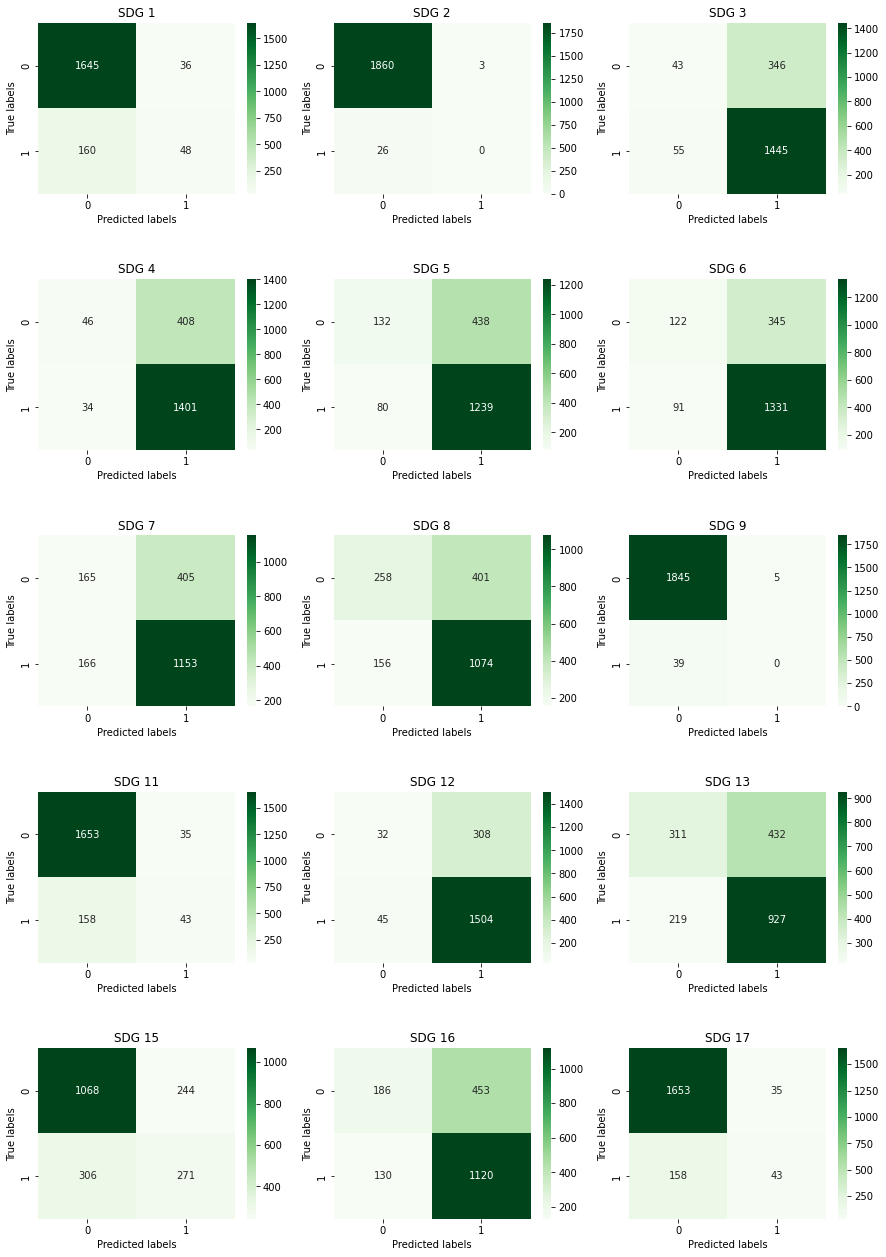

In [98]:
# Confusion matrices
sdgs = [1,2,3,4,5,6,7,8,9,11,12,13,15,16,17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,22))
plt.subplots_adjust(hspace = 0.5)
for ax in axes.flatten():
    cm = confusion_matrix(Y_test[:,counter], predictions[:,counter])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_title('SDG ' + str(sdgs[counter]))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    counter += 1

## 4. Classification with prior balancing of data

In [101]:
# Perform Grid Search to find optimal parameters 

# Pipeline: Resample data with smote and pass output to classifier
pipeline = Pipeline([('smote', SMOTE()), 
                     ('clf', LogisticRegression(solver='liblinear'))])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {'estimator__clf__C': [1,2]}

# Use stratified sampling
stratified_10_fold_cv = IterativeStratification(n_splits=2, order=1) # CHANGE TO 10
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average = 'weighted')
# Grid Search
grid_search = GridSearchCV(ovr, parameters, cv=stratified_10_fold_cv, scoring=scorer, n_jobs=-1, verbose=5)

grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=IterativeStratification(n_splits=2, order=1, random_state=None,
            sample_distribution_per_fold=None),
             estimator=OneVsRestClassifier(estimator=Pipeline(steps=[('smote',
                                                                      SMOTE()),
                                                                     ('clf',
                                                                      LogisticRegression(solver='liblinear'))])),
             n_jobs=-1, param_grid={'estimator__clf__C': [1, 2]},
             scoring=make_scorer(f1_score, average=weighted), verbose=5)

In [102]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'estimator__clf__C': 2}
OneVsRestClassifier(estimator=Pipeline(steps=[('smote', SMOTE()),
                                              ('clf',
                                               LogisticRegression(C=2,
                                                                  solver='liblinear'))]))
0.7695338915905705


              precision    recall  f1-score   support

           0       0.29      0.50      0.37       208
           1       0.14      0.31      0.19        26
           2       0.84      0.73      0.78      1500
           3       0.81      0.71      0.75      1435
           4       0.82      0.75      0.78      1319
           5       0.84      0.68      0.75      1422
           6       0.80      0.64      0.71      1319
           7       0.79      0.73      0.76      1230
           8       0.16      0.41      0.23        39
           9       0.29      0.51      0.37       201
          10       0.89      0.71      0.79      1549
          11       0.73      0.63      0.68      1146
          12       0.49      0.59      0.54       577
          13       0.79      0.70      0.74      1250
          14       0.29      0.51      0.37       201

   micro avg       0.74      0.68      0.71     13422
   macro avg       0.60      0.61      0.59     13422
weighted avg       0.78   

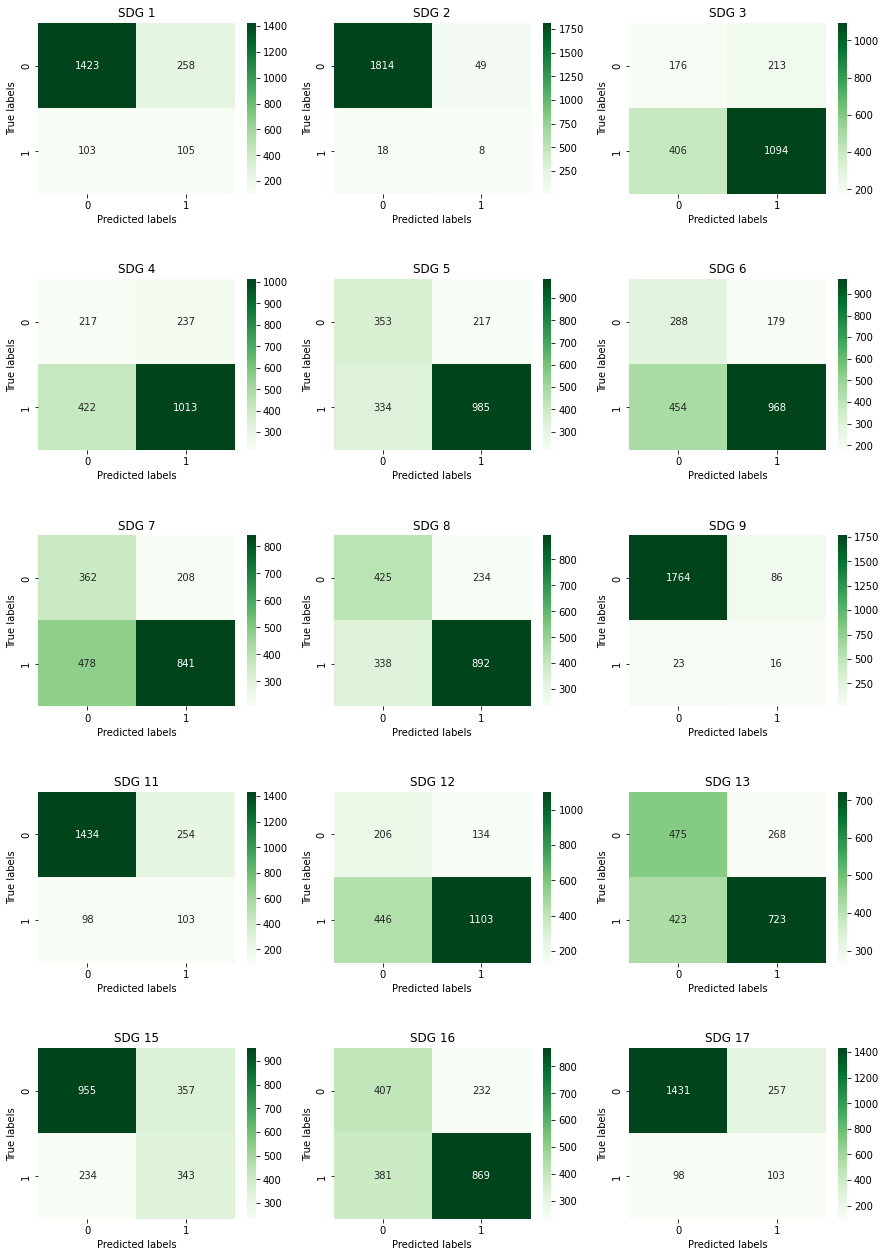

In [103]:
# Evaluation
predictions = grid_search.predict(X_test)
print(classification_report(Y_test, predictions))

sdgs = [1,2,3,4,5,6,7,8,9,11,12,13,15,16,17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,22))
plt.subplots_adjust(hspace = 0.5)
for ax in axes.flatten():
    cm = confusion_matrix(Y_test[:,counter], predictions[:,counter])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_title('SDG ' + str(sdgs[counter]))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    counter += 1

# Advanced method: build all-in-one-model (TO BE DONE, BERT example)

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 1. Data preprocessing

In [ ]:
# Tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(batch_1, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1800, 2), (100, 2), (100, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df[0].to_numpy(),
    targets=df[1].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
MAX_LEN = 512
BATCH_SIZE = 8 #16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


## 2. Sentiment classification

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['0','1']

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3709, 0.6291],
        [0.4411, 0.5589],
        [0.5565, 0.4435],
        [0.5164, 0.4836],
        [0.7622, 0.2378],
        [0.3911, 0.6089],
        [0.4666, 0.5334],
        [0.6456, 0.3544]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

RuntimeError: ignored

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()